In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shap
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import metrics 
import lime
import lime.lime_tabular
from pdpbox import pdp
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

In [3]:
org_data = pd.read_csv('Data.csv')
org_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41666 entries, 0 to 41665
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               41664 non-null  object 
 1   Comms and Services                 40812 non-null  float64
 2   Car Chargers                       40812 non-null  float64
 3   Space Heating                      40812 non-null  float64
 4   Hot Water                          40812 non-null  float64
 5   Sockets                            40812 non-null  float64
 6   Lighting                           40812 non-null  float64
 7   total_energy                       41664 non-null  object 
 8   datepart                           41664 non-null  float64
 9   weekend                            41664 non-null  object 
 10  bank holiday                       41664 non-null  object 
 11  hour                               41664 non-null  flo

C:\Users\mscVRstudent22\AppData\Local\Temp\ipykernel_40976\875856796.py:1: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  org_data = pd.read_csv('Data.csv')


In [4]:
# Generate a list of columns to drop
columns_to_drop = [col for col in org_data.columns if col.startswith('observation')]

# Drop these columns from the DataFrame
org_data = org_data.drop(columns=columns_to_drop)
org_data = org_data.dropna()
org_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40131 entries, 112 to 41663
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               40131 non-null  object 
 1   Comms and Services                 40131 non-null  float64
 2   Car Chargers                       40131 non-null  float64
 3   Space Heating                      40131 non-null  float64
 4   Hot Water                          40131 non-null  float64
 5   Sockets                            40131 non-null  float64
 6   Lighting                           40131 non-null  float64
 7   total_energy                       40131 non-null  object 
 8   datepart                           40131 non-null  float64
 9   weekend                            40131 non-null  object 
 10  bank holiday                       40131 non-null  object 
 11  hour                               40131 non-null  float6

In [5]:
df  = org_data

In [6]:
#Defining Function for turning features into cyclic 
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [7]:
# df['month'] = df.datetime.dt.month
df = encode(df, 'month', 12)
df =  encode(df, 'hour', 24)
# df['day'] = df.datetime.dt.day
# df = encode(df, 'day', 31)
df = encode(df, 'day of week', 7)
df = encode(df, 'day of month', 31)
df['working_hours'] = df['hour'].apply(lambda x: 8 <= x <= 17)
df['bank holiday'] = df['bank holiday'].astype(int)
df['weekend'] = df['weekend'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40131 entries, 112 to 41663
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               40131 non-null  object 
 1   Comms and Services                 40131 non-null  float64
 2   Car Chargers                       40131 non-null  float64
 3   Space Heating                      40131 non-null  float64
 4   Hot Water                          40131 non-null  float64
 5   Sockets                            40131 non-null  float64
 6   Lighting                           40131 non-null  float64
 7   total_energy                       40131 non-null  object 
 8   datepart                           40131 non-null  float64
 9   weekend                            40131 non-null  int32  
 10  bank holiday                       40131 non-null  int32  
 11  hour                               40131 non-null  float6

In [8]:
df

time  Comms and Services  Car Chargers  \
112    2019-04-05 16:00:00+00            0.590111      0.043272   
113    2019-04-05 17:00:00+00            0.590689      0.043253   
115    2019-04-05 19:00:00+00            0.590050      0.043139   
116    2019-04-05 20:00:00+00            0.589536      0.043031   
119    2019-04-05 23:00:00+00            0.589953      0.043239   
...                       ...                 ...           ...   
41659  2023-12-31 19:00:00+00            0.431266      0.000000   
41660  2023-12-31 20:00:00+00            0.431275      0.000000   
41661  2023-12-31 21:00:00+00            0.432384      0.000000   
41662  2023-12-31 22:00:00+00            0.431819      0.000000   
41663  2023-12-31 23:00:00+00            0.432600      0.000000   

       Space Heating  Hot Water   Sockets  Lighting total_energy  datepart  \
112         2.564617   0.076094  0.077019  0.756983  4.108097218   43560.0   
113         2.639575   0.000000  0.048581  0.208511  3.530608334   43560.0   
115         1.168772   0.000000  0.052336  0.151611  2.005908333   43560.0   
116         0.916325   0.000000  0.046442  0.151839  1.747172223   43560.0   
119         0.953847   0.087725  0.067442  0.173542  1.915747223   43560.0   
...              ...        ...       ...       ...          ...       ...   
41659       0.315221   0.000000  0.099255  0.233618  1.079359429   45291.0   
41660       1.168081   0.429653  0.103842  0.232898  2.365749757   45291.0   
41661       1.634023   0.000000  0.096170  0.213528   2.37610544   45291.0   
41662       1.580730   0.000000  0.100618  0.228981  2.342148396   45291.0   
41663       1.291073   0.000000  0.096448  0.213284  2.033403901   45291.0   

       weekend  ...  forecast_interval     month_sin  month_cos  hour_sin  \
112          0  ...           23:00:00  8.660254e-01       -0.5 -0.866025   
113          0  ...           22:00:00  8.660254e-01       -0.5 -0.965926   
115          0  ...           23:00:00  8.660254e-01       -0.5 -0.965926   
116          0  ...           22:00:00  8.660254e-01       -0.5 -0.866025   
119          0  ...           22:00:00  8.660254e-01       -0.5 -0.258819   
...        ...  ...                ...           ...        ...       ...   
41659        1  ...           23:00:00 -2.449294e-16        1.0 -0.965926   
41660        1  ...           22:00:00 -2.449294e-16        1.0 -0.866025   
41661        1  ...              1 day -2.449294e-16        1.0 -0.707107   
41662        1  ...           23:00:00 -2.449294e-16        1.0 -0.500000   
41663        1  ...           22:00:00 -2.449294e-16        1.0 -0.258819   

       hour_cos  day of week_sin day of week_cos day of month_sin  \
112   -0.500000        -0.974928       -0.222521     8.486443e-01   
113   -0.258819        -0.974928       -0.222521     8.486443e-01   
115    0.258819        -0.974928       -0.222521     8.486443e-01   
116    0.500000        -0.974928       -0.222521     8.486443e-01   
119    0.965926        -0.974928       -0.222521     8.486443e-01   
...         ...              ...             ...              ...   
41659  0.258819         0.000000        1.000000    -2.449294e-16   
41660  0.500000         0.000000        1.000000    -2.449294e-16   
41661  0.707107         0.000000        1.000000    -2.449294e-16   
41662  0.866025         0.000000        1.000000    -2.449294e-16   
41663  0.965926         0.000000        1.000000    -2.449294e-16   

       day of month_cos  working_hours  
112            0.528964           True  
113            0.528964           True  
115            0.528964          False  
116            0.528964          False  
119            0.528964          False  
...                 ...            ...  
41659          1.000000          False  
41660          1.000000          False  
41661          1.000000          False  
41662          1.000000          False  
41663          1.000000          False  

[40131 rows x 36 columns]

In [9]:
columns_to_convert = ['weekend','bank holiday']

# Convert 0 and 1 to boolean values in specified columns
df[columns_to_convert] = df[columns_to_convert].astype(bool)
# Sum specified columns to create 'total_aob_energy'
df['total_aob_energy'] = df[['Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting']].sum(axis=1, skipna=True)

# Drop the original columns except 'Car Chargers'
df.drop(['Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting','day of week','day of month','hour','month' ], axis=1, inplace=True)

# Now, 'df' contains the new 'total_aob_energy' column and has the specified columns dropped, except 'Car Chargers'

In [10]:
df

time  Car Chargers total_energy  datepart  weekend  \
112    2019-04-05 16:00:00+00      0.043272  4.108097218   43560.0    False   
113    2019-04-05 17:00:00+00      0.043253  3.530608334   43560.0    False   
115    2019-04-05 19:00:00+00      0.043139  2.005908333   43560.0    False   
116    2019-04-05 20:00:00+00      0.043031  1.747172223   43560.0    False   
119    2019-04-05 23:00:00+00      0.043239  1.915747223   43560.0    False   
...                       ...           ...          ...       ...      ...   
41659  2023-12-31 19:00:00+00      0.000000  1.079359429   45291.0     True   
41660  2023-12-31 20:00:00+00      0.000000  2.365749757   45291.0     True   
41661  2023-12-31 21:00:00+00      0.000000   2.37610544   45291.0     True   
41662  2023-12-31 22:00:00+00      0.000000  2.342148396   45291.0     True   
41663  2023-12-31 23:00:00+00      0.000000  2.033403901   45291.0     True   

       bank holiday    year       forecast_datadate          forecastperiod  \
112           False  2019.0  2019-04-05 16:00:00+00  2019-04-06 15:00:00+00   
113           False  2019.0  2019-04-05 17:00:00+00  2019-04-06 15:00:00+00   
115           False  2019.0  2019-04-05 19:00:00+00  2019-04-06 18:00:00+00   
116           False  2019.0  2019-04-05 20:00:00+00  2019-04-06 18:00:00+00   
119           False  2019.0  2019-04-05 23:00:00+00  2019-04-06 21:00:00+00   
...             ...     ...                     ...                     ...   
41659         False  2023.0  2023-12-31 19:00:00+00  2024-01-01 18:00:00+00   
41660         False  2023.0  2023-12-31 20:00:00+00  2024-01-01 18:00:00+00   
41661         False  2023.0  2023-12-31 21:00:00+00  2024-01-01 21:00:00+00   
41662         False  2023.0  2023-12-31 22:00:00+00  2024-01-01 21:00:00+00   
41663         False  2023.0  2023-12-31 23:00:00+00  2024-01-01 21:00:00+00   

       forecast_temperature  ...     month_sin  month_cos  hour_sin  hour_cos  \
112                    13.0  ...  8.660254e-01       -0.5 -0.866025 -0.500000   
113                    13.0  ...  8.660254e-01       -0.5 -0.965926 -0.258819   
115                    12.0  ...  8.660254e-01       -0.5 -0.965926  0.258819   
116                    12.0  ...  8.660254e-01       -0.5 -0.866025  0.500000   
119                    10.0  ...  8.660254e-01       -0.5 -0.258819  0.965926   
...                     ...  ...           ...        ...       ...       ...   
41659                  10.0  ... -2.449294e-16        1.0 -0.965926  0.258819   
41660                  10.0  ... -2.449294e-16        1.0 -0.866025  0.500000   
41661                  11.0  ... -2.449294e-16        1.0 -0.707107  0.707107   
41662                  11.0  ... -2.449294e-16        1.0 -0.500000  0.866025   
41663                  11.0  ... -2.449294e-16        1.0 -0.258819  0.965926   

       day of week_sin day of week_cos day of month_sin day of month_cos  \
112          -0.974928       -0.222521     8.486443e-01         0.528964   
113          -0.974928       -0.222521     8.486443e-01         0.528964   
115          -0.974928       -0.222521     8.486443e-01         0.528964   
116          -0.974928       -0.222521     8.486443e-01         0.528964   
119          -0.974928       -0.222521     8.486443e-01         0.528964   
...                ...             ...              ...              ...   
41659         0.000000        1.000000    -2.449294e-16         1.000000   
41660         0.000000        1.000000    -2.449294e-16         1.000000   
41661         0.000000        1.000000    -2.449294e-16         1.000000   
41662         0.000000        1.000000    -2.449294e-16         1.000000   
41663         0.000000        1.000000    -2.449294e-16         1.000000   

       working_hours  total_aob_energy  
112             True          4.064825  
113             True          3.487356  
115            False          1.962769  
116            False          1.704142  
119            False          1.8725

In [11]:
df['time'] = pd.to_datetime(df['time'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40131 entries, 112 to 41663
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   time                               40131 non-null  datetime64[ns, UTC]
 1   Car Chargers                       40131 non-null  float64            
 2   total_energy                       40131 non-null  object             
 3   datepart                           40131 non-null  float64            
 4   weekend                            40131 non-null  bool               
 5   bank holiday                       40131 non-null  bool               
 6   year                               40131 non-null  float64            
 7   forecast_datadate                  40131 non-null  object             
 8   forecastperiod                     40131 non-null  object             
 9   forecast_temperature               40131 non-null  fl

In [13]:
df = df.select_dtypes(exclude=['object'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40131 entries, 112 to 41663
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   time                               40131 non-null  datetime64[ns, UTC]
 1   Car Chargers                       40131 non-null  float64            
 2   datepart                           40131 non-null  float64            
 3   weekend                            40131 non-null  bool               
 4   bank holiday                       40131 non-null  bool               
 5   year                               40131 non-null  float64            
 6   forecast_temperature               40131 non-null  float64            
 7   forecast_feelslike                 40131 non-null  float64            
 8   forecast_weathertype               40131 non-null  float64            
 9   forecast_windspeed                 40131 non-null  fl

In [14]:
df.set_index('time', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40131 entries, 2019-04-05 16:00:00+00:00 to 2023-12-31 23:00:00+00:00
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Car Chargers                       40131 non-null  float64
 1   datepart                           40131 non-null  float64
 2   weekend                            40131 non-null  bool   
 3   bank holiday                       40131 non-null  bool   
 4   year                               40131 non-null  float64
 5   forecast_temperature               40131 non-null  float64
 6   forecast_feelslike                 40131 non-null  float64
 7   forecast_weathertype               40131 non-null  float64
 8   forecast_windspeed                 40131 non-null  float64
 9   forecast_uvindex                   40131 non-null  float64
 10  forecast_precipitationprobability  40131 non-null  float64
 11  month_s

In [17]:
print(df)

                           Car Chargers total_energy  datepart  weekend  \
time                                                                      
2019-04-05 16:00:00+00:00      0.043272  4.108097218   43560.0    False   
2019-04-05 17:00:00+00:00      0.043253  3.530608334   43560.0    False   
2019-04-05 19:00:00+00:00      0.043139  2.005908333   43560.0    False   
2019-04-05 20:00:00+00:00      0.043031  1.747172223   43560.0    False   
2019-04-05 23:00:00+00:00      0.043239  1.915747223   43560.0    False   
...                                 ...          ...       ...      ...   
2023-12-31 19:00:00+00:00      0.000000  1.079359429   45291.0     True   
2023-12-31 20:00:00+00:00      0.000000  2.365749757   45291.0     True   
2023-12-31 21:00:00+00:00      0.000000   2.37610544   45291.0     True   
2023-12-31 22:00:00+00:00      0.000000  2.342148396   45291.0     True   
2023-12-31 23:00:00+00:00      0.000000  2.033403901   45291.0     True   

                        

In [40]:
df.describe()

Car Chargers      datepart          year  forecast_temperature  \
count  40131.000000  40131.000000  40131.000000          40131.000000   
mean       0.946674  44431.794174   2021.125589             11.989484   
std        2.812122    502.157539      1.376723              4.480073   
min        0.000000  43560.000000   2019.000000             -2.000000   
25%        0.000000  43992.000000   2020.000000              9.000000   
50%        0.000000  44434.000000   2021.000000             12.000000   
75%        0.040278  44870.000000   2022.000000             16.000000   
max       27.065323  45291.000000   2023.000000             29.000000   

       forecast_feelslike  forecast_weathertype  forecast_windspeed  \
count        40131.000000          40131.000000        40131.000000   
mean             9.448855              6.355311           15.429444   
std              5.235029              4.851111            7.296837   
min             -7.000000              0.000000            2.000000   
25%              6.000000              2.000000            9.000000   
50%              9.000000              7.000000           13.000000   
75%             13.000000              8.000000           20.000000   
max             29.000000             30.000000           54.000000   

       forecast_uvindex  forecast_precipitationprobability     month_sin  \
count      40131.000000                       40131.000000  4.013100e+04   
mean           1.082754                          20.327801 -4.705900e-02   
std            1.603107                          27.735662  6.952838e-01   
min            0.000000                           0.000000 -1.000000e+00   
25%            0.000000                           1.000000 -8.660254e-01   
50%            1.000000                           6.000000 -2.449294e-16   
75%            1.000000                          34.000000  5.000000e-01   
max            8.000000                          98.000000  1.000000e+00   

          month_cos      hour_sin      hour_cos  day of week_sin  \
count  4.013100e+04  40131.000000  4.013100e+04     40131.000000   
mean  -2.567369e-02     -0.004189  7.827268e-04         0.002019   
std    7.167507e-01      0.706217  7.080006e-01         0.708151   
min   -1.000000e+00     -1.000000 -1.000000e+00        -0.974928   
25%   -8.660254e-01     -0.707107 -7.071068e-01        -0.781831   
50%   -1.836970e-16      0.000000 -1.836970e-16         0.000000   
75%    5.000000e-01      0.707107  7.071068e-01         0.781831   
max    1.000000e+00      1.000000  1.000000e+00         0.974928   

       day of week_cos  day of month_sin  day of month_cos  total_aob_energy  
count     40131.000000      4.013100e+04      40131.000000      40131.000000  
mean          0.005561     -1.776197e-03         -0.020182          2.027650  
std           0.706054      7.148469e-01          0.699005          1.434310  
min          -0.900969     -9.987165e-01         -0.994869          0.000000  
25%          -0.900969     -7.247928e-01         -0.758758          1.076624  
50%          -0.222521     -2.449294e-16         -0.050649          1.398340  
75%           0.623490      7.247928e-01          0.688967          2.549083  
max           1.000000      9.987165e-01          1.000000         11.838856

In [15]:
null_counts = df.isnull().sum()
print(null_counts)

Car Chargers                         0
datepart                             0
weekend                              0
bank holiday                         0
year                                 0
forecast_temperature                 0
forecast_feelslike                   0
forecast_weathertype                 0
forecast_windspeed                   0
forecast_uvindex                     0
forecast_precipitationprobability    0
month_sin                            0
month_cos                            0
hour_sin                             0
hour_cos                             0
day of week_sin                      0
day of week_cos                      0
day of month_sin                     0
day of month_cos                     0
working_hours                        0
total_aob_energy                     0
dtype: int64


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40131 entries, 2019-04-05 16:00:00+00:00 to 2023-12-31 23:00:00+00:00
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Car Chargers                       40131 non-null  float64
 1   datepart                           40131 non-null  float64
 2   weekend                            40131 non-null  bool   
 3   bank holiday                       40131 non-null  bool   
 4   year                               40131 non-null  float64
 5   forecast_temperature               40131 non-null  float64
 6   forecast_feelslike                 40131 non-null  float64
 7   forecast_weathertype               40131 non-null  float64
 8   forecast_windspeed                 40131 non-null  float64
 9   forecast_uvindex                   40131 non-null  float64
 10  forecast_precipitationprobability  40131 non-null  float64
 11  month_s

In [17]:
new_columns = []
for col in df.columns:
    # Remove "Forecast_" if it exists and capitalize the first letter of the remaining string
    if col.startswith('forecast_'):
        new_name = col.replace('forecast_', '')  # Remove 'Forecast_'
        new_name = new_name.capitalize()  # Capitalize the first letter
    else:
        new_name = col  # Keep the original name if it doesn't start with 'Forecast_'
    new_columns.append(new_name)

# Assign the modified column names back to the DataFrame
df.columns = new_columns


In [18]:
df.columns = [col.capitalize() for col in df.columns]

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40131 entries, 2019-04-05 16:00:00+00:00 to 2023-12-31 23:00:00+00:00
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Car chargers              40131 non-null  float64
 1   Datepart                  40131 non-null  float64
 2   Weekend                   40131 non-null  bool   
 3   Bank holiday              40131 non-null  bool   
 4   Year                      40131 non-null  float64
 5   Temperature               40131 non-null  float64
 6   Feelslike                 40131 non-null  float64
 7   Weathertype               40131 non-null  float64
 8   Windspeed                 40131 non-null  float64
 9   Uvindex                   40131 non-null  float64
 10  Precipitationprobability  40131 non-null  float64
 11  Month_sin                 40131 non-null  float64
 12  Month_cos                 40131 non-null  float64
 13  Hour_sin      

In [19]:
df = df.drop(["Car chargers","Datepart"],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40131 entries, 2019-04-05 16:00:00+00:00 to 2023-12-31 23:00:00+00:00
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Weekend                   40131 non-null  bool   
 1   Bank holiday              40131 non-null  bool   
 2   Year                      40131 non-null  float64
 3   Temperature               40131 non-null  float64
 4   Feelslike                 40131 non-null  float64
 5   Weathertype               40131 non-null  float64
 6   Windspeed                 40131 non-null  float64
 7   Uvindex                   40131 non-null  float64
 8   Precipitationprobability  40131 non-null  float64
 9   Month_sin                 40131 non-null  float64
 10  Month_cos                 40131 non-null  float64
 11  Hour_sin                  40131 non-null  float64
 12  Hour_cos                  40131 non-null  float64
 13  Day of week_si

In [20]:
df_filtered = df['2022':]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17270 entries, 2022-01-01 00:00:00+00:00 to 2023-12-31 23:00:00+00:00
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Weekend                   17270 non-null  bool   
 1   Bank holiday              17270 non-null  bool   
 2   Year                      17270 non-null  float64
 3   Temperature               17270 non-null  float64
 4   Feelslike                 17270 non-null  float64
 5   Weathertype               17270 non-null  float64
 6   Windspeed                 17270 non-null  float64
 7   Uvindex                   17270 non-null  float64
 8   Precipitationprobability  17270 non-null  float64
 9   Month_sin                 17270 non-null  float64
 10  Month_cos                 17270 non-null  float64
 11  Hour_sin                  17270 non-null  float64
 12  Hour_cos                  17270 non-null  float64
 13  Day of week_si

In [131]:
data_daily = df.resample('D').mean()
print(data_daily)

                           Weekend  Bank holiday    Year  Temperature  \
time                                                                    
2019-04-05 00:00:00+00:00      0.0           0.0  2019.0    12.000000   
2019-04-06 00:00:00+00:00      1.0           0.0  2019.0     8.285714   
2019-04-07 00:00:00+00:00      1.0           0.0  2019.0    11.181818   
2019-04-08 00:00:00+00:00      0.0           0.0  2019.0     9.791667   
2019-04-09 00:00:00+00:00      0.0           0.0  2019.0     9.083333   
...                            ...           ...     ...          ...   
2023-12-27 00:00:00+00:00      0.0           0.0  2023.0    10.750000   
2023-12-28 00:00:00+00:00      0.0           0.0  2023.0     8.750000   
2023-12-29 00:00:00+00:00      0.0           0.0  2023.0     9.375000   
2023-12-30 00:00:00+00:00      1.0           0.0  2023.0     9.000000   
2023-12-31 00:00:00+00:00      1.0           0.0  2023.0     8.875000   

                           Feelslike  Weathertype 

In [43]:
data_daily_cleaned = data_daily.iloc[:, 2:]  # Keep columns from index 2 onwards
data_daily_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1732 entries, 2019-04-05 00:00:00+00:00 to 2023-12-31 00:00:00+00:00
Freq: D
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Weekend                   1723 non-null   float64
 1   Bank holiday              1723 non-null   float64
 2   Year                      1723 non-null   float64
 3   Temperature               1723 non-null   float64
 4   Feelslike                 1723 non-null   float64
 5   Weathertype               1723 non-null   float64
 6   Windspeed                 1723 non-null   float64
 7   Uvindex                   1723 non-null   float64
 8   Precipitationprobability  1723 non-null   float64
 9   Month_sin                 1723 non-null   float64
 10  Month_cos                 1723 non-null   float64
 11  Hour_sin                  1723 non-null   float64
 12  Hour_cos                  1723 non-null   float64
 13  Day of 

In [34]:
data_daily_cleaned = data_daily.iloc[:, 5:11] 
data_daily_cleaned = data_daily_cleaned.join(data_daily["Total_aob_energy"])

In [35]:
data_daily_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1732 entries, 2019-04-05 00:00:00+00:00 to 2023-12-31 00:00:00+00:00
Freq: D
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature               1723 non-null   float64
 1   Feelslike                 1723 non-null   float64
 2   Weathertype               1723 non-null   float64
 3   Windspeed                 1723 non-null   float64
 4   Uvindex                   1723 non-null   float64
 5   Precipitationprobability  1723 non-null   float64
 6   Total_aob_energy          1723 non-null   float64
dtypes: float64(7)
memory usage: 108.2 KB


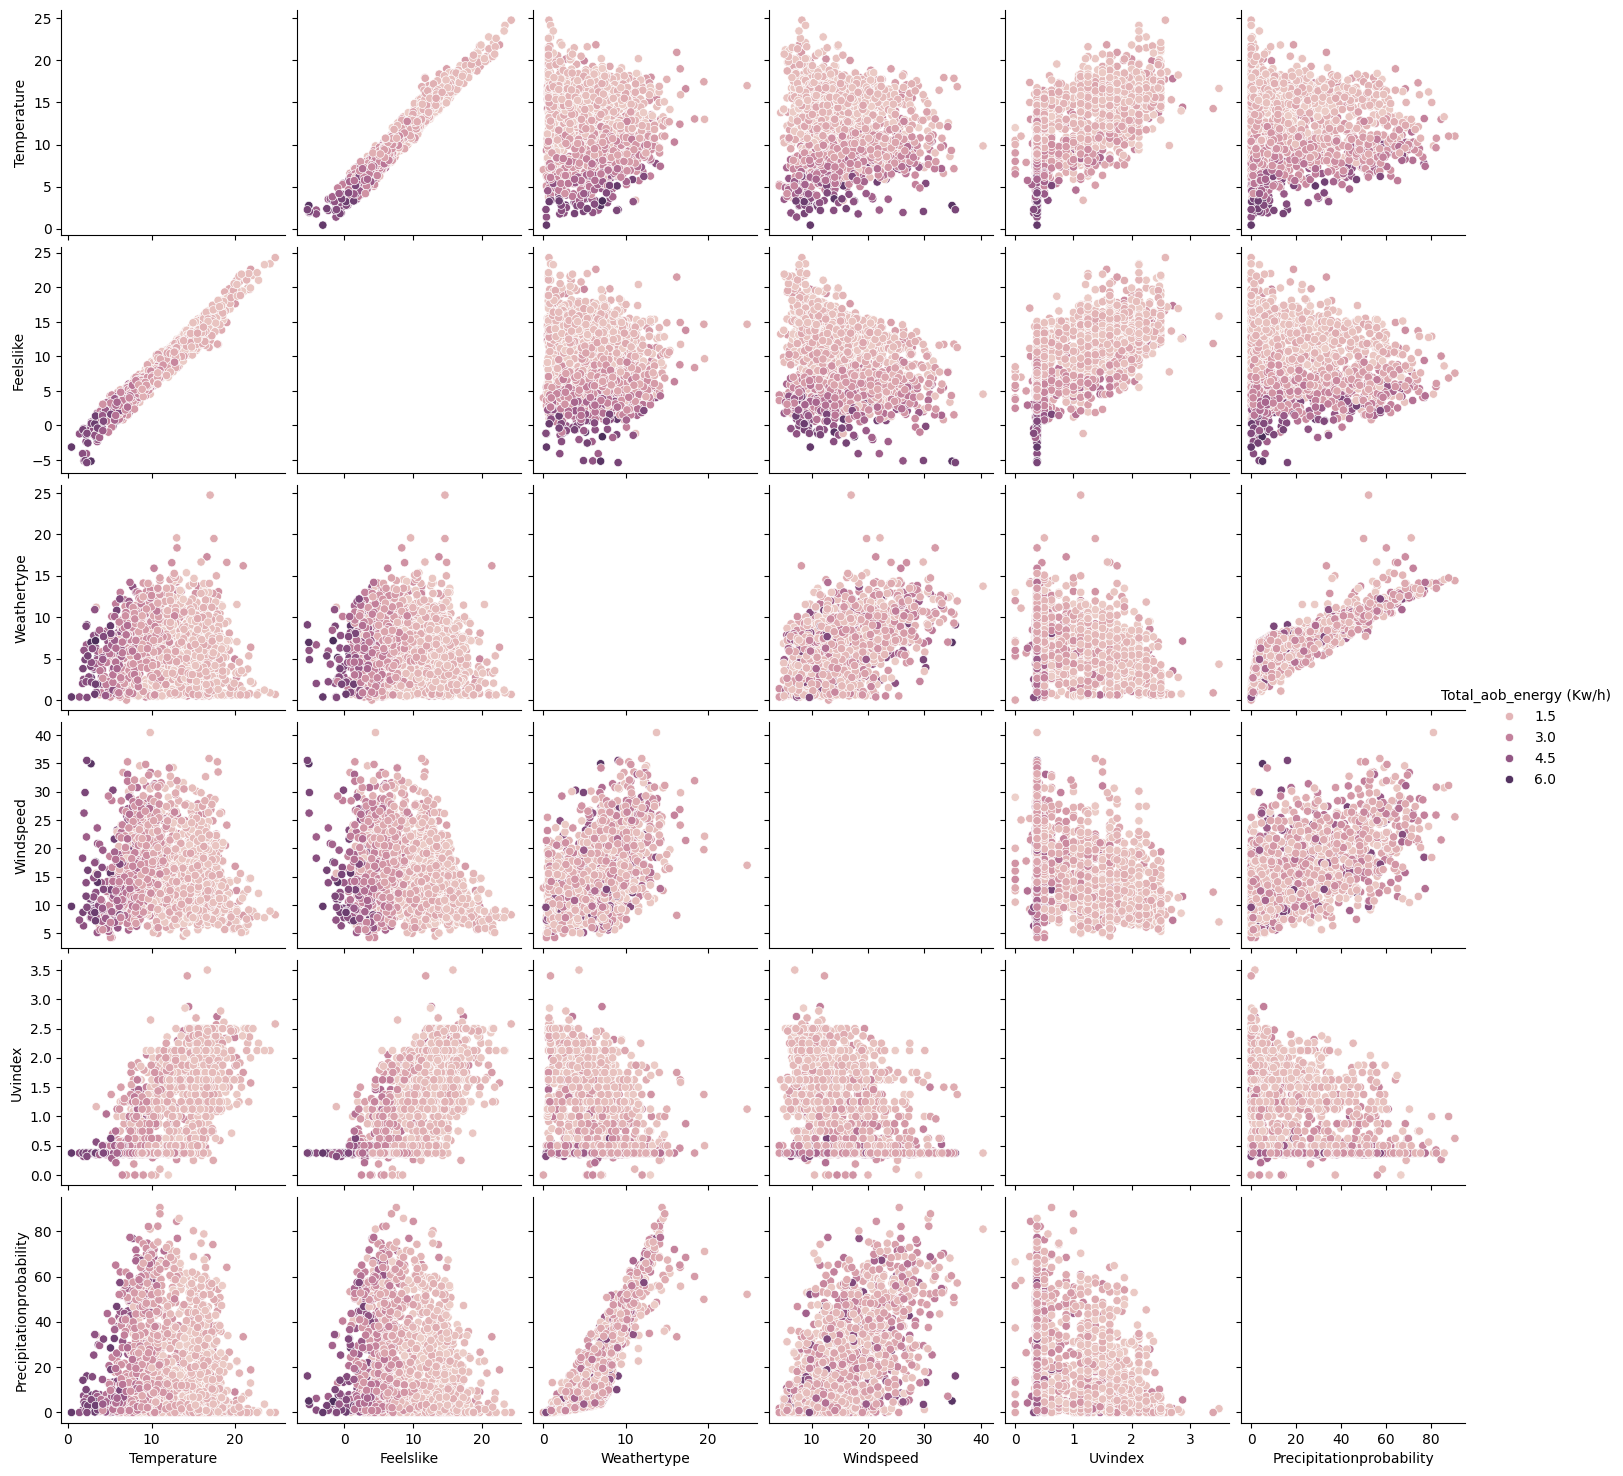

In [36]:
# Create the pairplot
pairplot = sns.pairplot(data_daily_cleaned, hue='Total_aob_energy')

# Ensure legend is created and then retrieve it
# Use pairplot._legend, which should exist after creating the pairplot
legend = pairplot._legend

# Check if the legend exists before trying to set the title
if legend is not None:
    legend.set_title("Total_aob_energy (Kw/h)")

# Show the plot
plt.show()

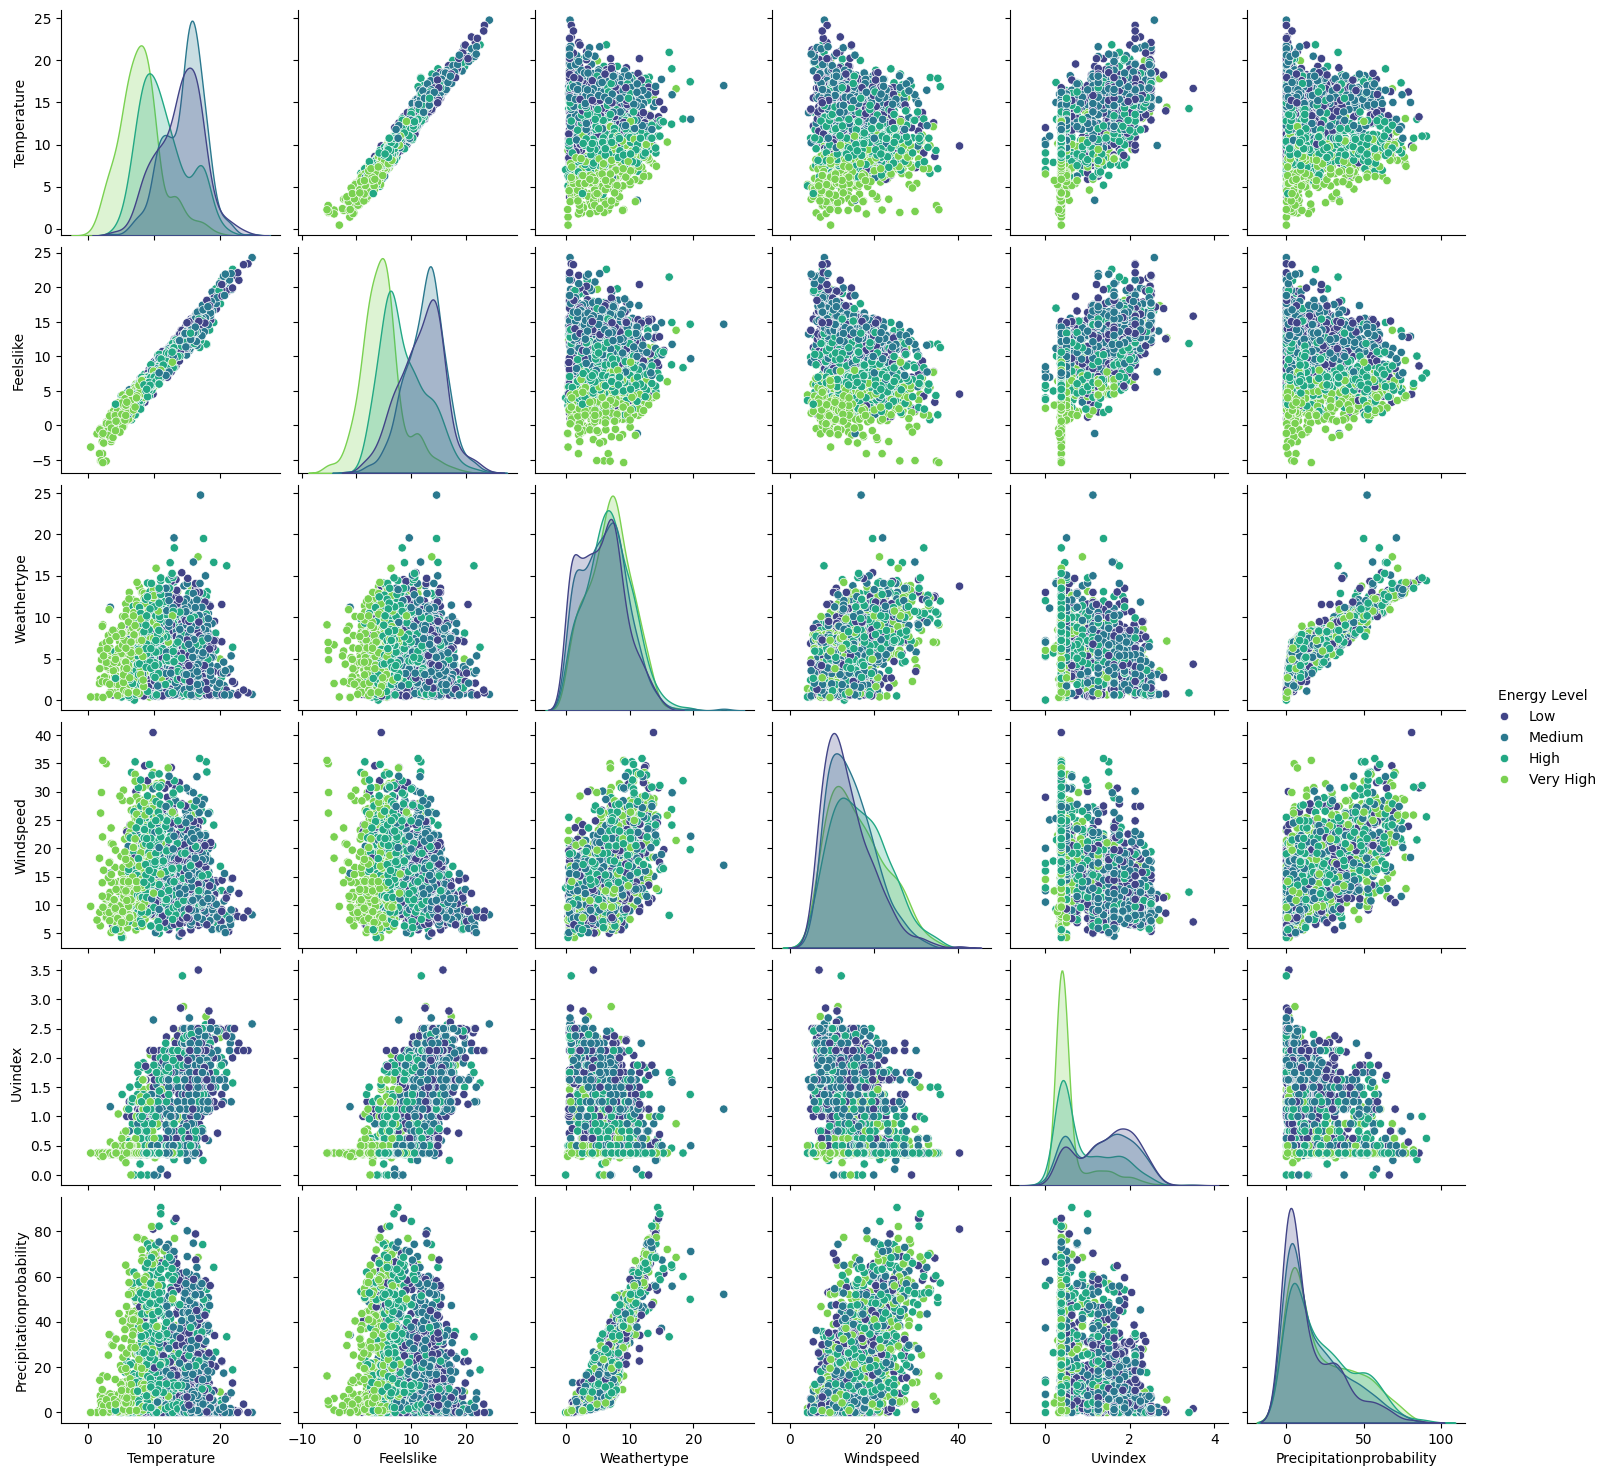

In [41]:
energy_bins = pd.qcut(data_daily_cleaned['Total_aob_energy'], q=4, labels=["Low", "Medium", "High", "Very High"])
# Drop these columns from the DataFrame
# df = df.drop(columns=columns_to_drop)


data_daily_cleaned['Energy Level'] = energy_bins
data_daily_cleaned = data_daily_cleaned.drop(['Total_aob_energy'], axis = 1)
# Plot using pairplot with the new 'Energy Level' column as hue
sns.pairplot(data_daily_cleaned, hue='Energy Level', palette="viridis")

In [104]:
data_daily.dropna(inplace=True)

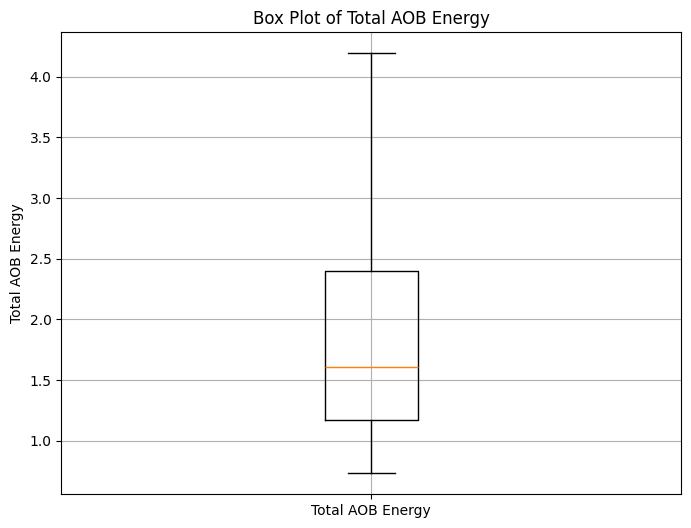

In [144]:

plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
plt.boxplot(data_daily['Total_aob_energy'])
plt.title('Box Plot of Total AOB Energy')  # Adding a title
plt.ylabel('Total AOB Energy')  # Labeling the y-axis
plt.xticks([1], ['Total AOB Energy'])  # Labeling x-axis ticks
plt.grid(True)  # Adding a grid for better readability
plt.show()  # Display the plot

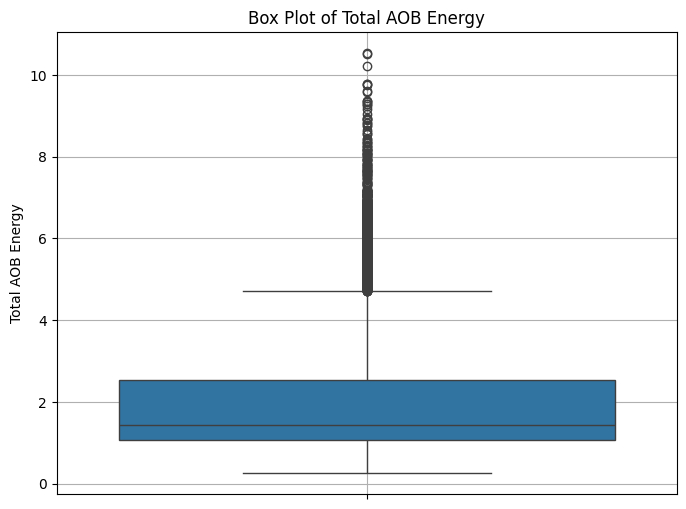

In [76]:
# Creating a box plot using Seaborn, which might provide a more aesthetically pleasing result by default
plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
sns.boxplot(data=df_filtered, y='Total_aob_energy')
plt.title('Box Plot of Total AOB Energy')  # Adding a title
plt.ylabel('Total AOB Energy')  # Labeling the y-axis
plt.grid(True)  # Adding a grid for better readability
plt.show()  # Display the plot

In [47]:
# df['Total_aob_energy'] = df['Total_aob_energy'].astype(int)

In [63]:
zero_count = (df["Total_aob_energy"] < 0.3).sum()

In [64]:
print(zero_count)

22


In [107]:
df_filtered = df[df['Total_aob_energy'] > 1.0]

In [21]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17270 entries, 2022-01-01 00:00:00+00:00 to 2023-12-31 23:00:00+00:00
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Weekend                   17270 non-null  bool   
 1   Bank holiday              17270 non-null  bool   
 2   Year                      17270 non-null  float64
 3   Temperature               17270 non-null  float64
 4   Feelslike                 17270 non-null  float64
 5   Weathertype               17270 non-null  float64
 6   Windspeed                 17270 non-null  float64
 7   Uvindex                   17270 non-null  float64
 8   Precipitationprobability  17270 non-null  float64
 9   Month_sin                 17270 non-null  float64
 10  Month_cos                 17270 non-null  float64
 11  Hour_sin                  17270 non-null  float64
 12  Hour_cos                  17270 non-null  float64
 13  Day of week_si

In [133]:
data_daily = data_daily.dropna()

In [154]:
df_no_outlier = df[df['Total_aob_energy']<= 7]


In [155]:
df

Weekend  Bank holiday    Year  Temperature  \
time                                                                    
2019-04-05 16:00:00+00:00    False         False  2019.0         13.0   
2019-04-05 17:00:00+00:00    False         False  2019.0         13.0   
2019-04-05 19:00:00+00:00    False         False  2019.0         12.0   
2019-04-05 20:00:00+00:00    False         False  2019.0         12.0   
2019-04-05 23:00:00+00:00    False         False  2019.0         10.0   
...                            ...           ...     ...          ...   
2023-12-31 19:00:00+00:00     True         False  2023.0         10.0   
2023-12-31 20:00:00+00:00     True         False  2023.0         10.0   
2023-12-31 21:00:00+00:00     True         False  2023.0         11.0   
2023-12-31 22:00:00+00:00     True         False  2023.0         11.0   
2023-12-31 23:00:00+00:00     True         False  2023.0         11.0   

                           Feelslike  Weathertype  Windspeed  Uvindex  \
time                                                                    
2019-04-05 16:00:00+00:00       10.0          7.0       16.0      2.0   
2019-04-05 17:00:00+00:00       10.0          7.0       16.0      2.0   
2019-04-05 19:00:00+00:00        9.0          7.0       13.0      1.0   
2019-04-05 20:00:00+00:00        9.0          7.0       13.0      1.0   
2019-04-05 23:00:00+00:00        7.0          7.0       11.0      0.0   
...                              ...          ...        ...      ...   
2023-12-31 19:00:00+00:00        6.0         15.0       22.0      0.0   
2023-12-31 20:00:00+00:00        6.0         15.0       22.0      0.0   
2023-12-31 21:00:00+00:00        7.0         15.0       34.0      0.0   
2023-12-31 22:00:00+00:00        7.0         15.0       34.0      0.0   
2023-12-31 23:00:00+00:00        7.0         15.0       34.0      0.0   

                           Precipitationprobability     Month_sin  Month_cos  \
time                                                                           
2019-04-05 16:00:00+00:00                       3.0  8.660254e-01       -0.5   
2019-04-05 17:00:00+00:00                       3.0  8.660254e-01       -0.5   
2019-04-05 19:00:00+00:00                       4.0  8.660254e-01       -0.5   
2019-04-05 20:00:00+00:00                       4.0  8.660254e-01       -0.5   
2019-04-05 23:00:00+00:00                       4.0  8.660254e-01       -0.5   
...                                             ...           ...        ...   
2023-12-31 19:00:00+00:00                      96.0 -2.449294e-16        1.0   
2023-12-31 20:00:00+00:00                      97.0 -2.449294e-16        1.0   
2023-12-31 21:00:00+00:00                      96.0 -2.449294e-16        1.0   
2023-12-31 22:00:00+00:00                      96.0 -2.449294e-16        1.0   
2023-12-31 23:00:00+00:00                      96.0 -2.449294e-16        1.0   

                           Hour_sin  Hour_cos  Day of week_sin  \
time                                                             
2019-04-05 16:00:00+00:00 -0.866025 -0.500000        -0.974928   
2019-04-05 17:00:00+00:00 -0.965926 -0.258819        -0.974928   
2019-04-05 19:00:00+00:00 -0.965926  0.258819        -0.974928   
2019-04-05 20:00:00+00:00 -0.866025  0.500000        -0.974928   
2019-04-05 23:00:00+00:00 -0.258819  0.965926        -0.974928   
...                             ...       ...              ...   
2023-12-31 19:00:00+00:00 -0.965926  0.258819         0.000000   
2023-12-31 20:00:00+00:00 -0.866025  0.500000         0.000000   
2023-12-31 21:00:00+00:00 -0.707107  0.707107         0.000000   
2023-12-31 22:00:00+00:00 -0.500000  0.866025         0.000000   
2023-12-31 23:00:00+00:00 -0.258819  0.965926         0.000000   

                           Day of week_cos  Day of month_sin  \
time                                                           
2019-04-05 16:00:00+00:00        -0.222521      8.486443e-01   
2019-04-05 17:00:00+00:00        -0

In [151]:
X = df_no_outlier.drop(['Year','Total_aob_energy'], axis=1)  # Assuming 'energy_consumption' is the target variable
y = df_no_outlier['Total_aob_energy']

In [50]:
data_daily_cleaned = data_daily_cleaned.dropna()

In [86]:
data_daily_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1723 entries, 2019-04-05 00:00:00+00:00 to 2023-12-31 00:00:00+00:00
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Weekend                   1723 non-null   float64
 1   Bank holiday              1723 non-null   float64
 2   Year                      1723 non-null   float64
 3   Temperature               1723 non-null   float64
 4   Feelslike                 1723 non-null   float64
 5   Weathertype               1723 non-null   float64
 6   Windspeed                 1723 non-null   float64
 7   Uvindex                   1723 non-null   float64
 8   Precipitationprobability  1723 non-null   float64
 9   Month_sin                 1723 non-null   float64
 10  Month_cos                 1723 non-null   float64
 11  Hour_sin                  1723 non-null   float64
 12  Hour_cos                  1723 non-null   float64
 13  Day of week_sin

In [22]:
df_filtered_daily = df_filtered.resample('D').mean()
df_filtered_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2022-01-01 00:00:00+00:00 to 2023-12-31 00:00:00+00:00
Freq: D
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Weekend                   730 non-null    float64
 1   Bank holiday              730 non-null    float64
 2   Year                      730 non-null    float64
 3   Temperature               730 non-null    float64
 4   Feelslike                 730 non-null    float64
 5   Weathertype               730 non-null    float64
 6   Windspeed                 730 non-null    float64
 7   Uvindex                   730 non-null    float64
 8   Precipitationprobability  730 non-null    float64
 9   Month_sin                 730 non-null    float64
 10  Month_cos                 730 non-null    float64
 11  Hour_sin                  730 non-null    float64
 12  Hour_cos                  730 non-null    float64
 13  Day of w

In [123]:
df_filtered_daily_rmoutlier = df_filtered_daily[df_filtered_daily["Total_aob_energy"]< 4.5]
df_filtered_daily_rmoutlier.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 709 entries, 2022-01-01 00:00:00+00:00 to 2023-12-31 00:00:00+00:00
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Weekend                   709 non-null    float64
 1   Bank holiday              709 non-null    float64
 2   Year                      709 non-null    float64
 3   Temperature               709 non-null    float64
 4   Feelslike                 709 non-null    float64
 5   Weathertype               709 non-null    float64
 6   Windspeed                 709 non-null    float64
 7   Uvindex                   709 non-null    float64
 8   Precipitationprobability  709 non-null    float64
 9   Month_sin                 709 non-null    float64
 10  Month_cos                 709 non-null    float64
 11  Hour_sin                  709 non-null    float64
 12  Hour_cos                  709 non-null    float64
 13  Day of week_sin 

In [126]:
# Calculate the mean of the data excluding the outliers
mean_value = df_filtered_daily[df_filtered_daily["Total_aob_energy"] < 4.5]["Total_aob_energy"].mean()

# Replace values greater than or equal to 4.5 with the calculated mean
df_filtered_daily["Total_aob_energy"] = df_filtered_daily["Total_aob_energy"].apply(lambda x: mean_value if x >= 4.5 else x)

In [23]:
X_day = df_filtered_daily.drop(['Total_aob_energy','Year'], axis = 1)
y_day = df_filtered_daily['Total_aob_energy']

In [94]:
X

Weekend  Bank holiday  Temperature  Feelslike  \
time                                                                       
2019-04-05 16:00:00+00:00    False         False         13.0       10.0   
2019-04-05 17:00:00+00:00    False         False         13.0       10.0   
2019-04-05 19:00:00+00:00    False         False         12.0        9.0   
2019-04-05 20:00:00+00:00    False         False         12.0        9.0   
2019-04-05 23:00:00+00:00    False         False         10.0        7.0   
...                            ...           ...          ...        ...   
2023-12-31 19:00:00+00:00     True         False         10.0        6.0   
2023-12-31 20:00:00+00:00     True         False         10.0        6.0   
2023-12-31 21:00:00+00:00     True         False         11.0        7.0   
2023-12-31 22:00:00+00:00     True         False         11.0        7.0   
2023-12-31 23:00:00+00:00     True         False         11.0        7.0   

                           Weathertype  Windspeed  Uvindex  \
time                                                         
2019-04-05 16:00:00+00:00          7.0       16.0      2.0   
2019-04-05 17:00:00+00:00          7.0       16.0      2.0   
2019-04-05 19:00:00+00:00          7.0       13.0      1.0   
2019-04-05 20:00:00+00:00          7.0       13.0      1.0   
2019-04-05 23:00:00+00:00          7.0       11.0      0.0   
...                                ...        ...      ...   
2023-12-31 19:00:00+00:00         15.0       22.0      0.0   
2023-12-31 20:00:00+00:00         15.0       22.0      0.0   
2023-12-31 21:00:00+00:00         15.0       34.0      0.0   
2023-12-31 22:00:00+00:00         15.0       34.0      0.0   
2023-12-31 23:00:00+00:00         15.0       34.0      0.0   

                           Precipitationprobability     Month_sin  Month_cos  \
time                                                                           
2019-04-05 16:00:00+00:00                       3.0  8.660254e-01       -0.5   
2019-04-05 17:00:00+00:00                       3.0  8.660254e-01       -0.5   
2019-04-05 19:00:00+00:00                       4.0  8.660254e-01       -0.5   
2019-04-05 20:00:00+00:00                       4.0  8.660254e-01       -0.5   
2019-04-05 23:00:00+00:00                       4.0  8.660254e-01       -0.5   
...                                             ...           ...        ...   
2023-12-31 19:00:00+00:00                      96.0 -2.449294e-16        1.0   
2023-12-31 20:00:00+00:00                      97.0 -2.449294e-16        1.0   
2023-12-31 21:00:00+00:00                      96.0 -2.449294e-16        1.0   
2023-12-31 22:00:00+00:00                      96.0 -2.449294e-16        1.0   
2023-12-31 23:00:00+00:00                      96.0 -2.449294e-16        1.0   

                           Hour_sin  Hour_cos  Day of week_sin  \
time                                                             
2019-04-05 16:00:00+00:00 -0.866025 -0.500000        -0.974928   
2019-04-05 17:00:00+00:00 -0.965926 -0.258819        -0.974928   
2019-04-05 19:00:00+00:00 -0.965926  0.258819        -0.974928   
2019-04-05 20:00:00+00:00 -0.866025  0.500000        -0.974928   
2019-04-05 23:00:00+00:00 -0.258819  0.965926        -0.974928   
...                             ...       ...              ...   
2023-12-31 19:00:00+00:00 -0.965926  0.258819         0.000000   
2023-12-31 20:00:00+00:00 -0.866025  0.500000         0.000000   
2023-12-31 21:00:00+00:00 -0.707107  0.707107         0.000000   
2023-12-31 22:00:00+00:00 -0.500000  0.866025         0.000000   
2023-12-31 23:00:00+00:00 -0.258819  0.965926         0.000000   

                           Day of week_cos  Day of month_sin  \
time                                                           
2019-04-05 16:00:00+00:00        -0.222521      8.486443e-01   
2019-04-05 17:00:00+00:00        -0.222521      8.486443e-01   
2019-04-05 19:00:00+00:00        -0.222521      8.486443e-01   
2019-04-05 

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Model Training
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

#gradient-boosted regression model
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)

#Ridge Model 
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

#Lasso Model
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

#Support Vector Regression 
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Model Evaluation
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gbr = gbr_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)

#https://stats.stackexchange.com/questions/255276/normalized-root-mean-square-error-nrmse-with-zero-mean-of-observed-value
# Calculate range of the target variable
y_range = np.max(y_test) - np.min(y_test)
# Calculate the mean of the target variable
y_mean = np.mean(y_test)
# Calculate RMSE for Linear Regression
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
# Calculate Normalised RMSE for Linear Regression
lr_nrmse = lr_rmse / y_range
# Calculate rRMSE (relative RMSE) for Linear Regression, normalized by the mean of y_test
lr_rrmse = lr_rmse / y_mean
# Calculate MAE
lr_mae = np.mean(np.abs(y_test - y_pred_lr))
print("Mean Absolute Error (MAE) for Linear Regression:", lr_mae)
# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
lr_mape = np.mean(np.abs((y_test - y_pred_lr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Linear Regression:", lr_mape, "%")

print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression NRMSE:", lr_nrmse)
print("Linear Regression rRMSE:", lr_rrmse)



# Calculate normalised RMSE for Random Forest
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# Calculate Normalised RMSE for Random Forest
rf_nrmse = rf_rmse / y_range
# Calculate rRMSE (relative RMSE) for Random Forest, normalised by the mean of y_test
rf_rrmse = rf_rmse / y_mean
# Calculate MAE
rf_mae = np.mean(np.abs(y_test - y_pred_rf))
print("Mean Absolute Error (MAE) for Random Forest:", rf_mae)
# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
rf_mape = np.mean(np.abs((y_test - y_pred_rf) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Random Forest:", rf_mape, "%")
print("Random Forest RMSE:", rf_rmse)
print("Random Forest NRMSE:", rf_nrmse)
print("Random Forest rRMSE:", rf_rrmse)



# Calculate nomrlaised RMSE for Gradient-boosted Regression
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
# Calculate Normalised RMSE for Gradient-boosted regression
gbr_nrmse = gbr_rmse / y_range
# Calculate rRMSE (relative RMSE) for Gradient boosting, normalised by the mean of y_test
gbr_rrmse = gbr_rmse / y_mean
# Calculate MAE
gbr_mae = np.mean(np.abs(y_test - y_pred_gbr))
print("Mean Absolute Error (MAE) for Gradient Boosting Regression:", gbr_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
gbr_mape = np.mean(np.abs((y_test - y_pred_gbr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Gradient Boosting Regression:", gbr_mape, "%")
print("Gradient Boosting Regression RMSE:", gbr_rmse)
print("Gradient Boosting Regression NRMSE:", gbr_nrmse)
print("Gradient Boosting Regression rRMSE:", gbr_rrmse)

# Calculate nomrlaised RMSE for Ridge
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
# Calculate Normalised RMSE for Ridge regression
ridge_nrmse = ridge_rmse / y_range
# Calculate rRMSE (relative RMSE) for Ridge, normalised by the mean of y_test
ridge_rrmse = ridge_rmse / y_mean
# Calculate MAE
ridge_mae = np.mean(np.abs(y_test - y_pred_ridge))
print("Mean Absolute Error (MAE) for Ridge:", ridge_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
ridge_mape = np.mean(np.abs((y_test - y_pred_ridge) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Ridge:", ridge_mape, "%")
print("Ridge RMSE:", ridge_rmse)
print("Ridge NRMSE:", ridge_nrmse)
print("Ridge rRMSE:", ridge_rrmse)



# Calculate nomrlaised RMSE for Lasso
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
# Calculate Normalised RMSE for Lasso regression
lasso_nrmse = lasso_rmse / y_range
# Calculate rRMSE (relative RMSE) for Lasso, normalised by the mean of y_test
lasso_rrmse = lasso_rmse / y_mean
# Calculate MAE
lasso_mae = np.mean(np.abs(y_test - y_pred_lasso))
print("Mean Absolute Error (MAE) for Lasso:", lasso_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
lasso_mape = np.mean(np.abs((y_test - y_pred_lasso) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Lasso:", lasso_mape, "%")
print("Lasso RMSE:", lasso_rmse)
print("Lasso NRMSE:", lasso_nrmse)
print("Lasso rRMSE:", lasso_rrmse)

# Calculate nomrlaised RMSE for support vector regression
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))
# Calculate Normalised RMSE for support vector regression regression
svr_nrmse = svr_rmse / y_range
# Calculate rRMSE (relative RMSE) for support vector regression, normalised by the mean of y_test
svr_rrmse = svr_rmse / y_mean
# Calculate MAE
svr_mae = np.mean(np.abs(y_test - y_pred_svr))
print("Mean Absolute Error (MAE) for SVR:", svr_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
svr_mape = np.mean(np.abs((y_test - y_pred_svr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for SVR:", svr_mape, "%")
print("SVR RMSE:", svr_rmse)
print("SVR NRMSE:", svr_nrmse)
print("SVR rRMSE:", svr_rrmse)

Mean Absolute Error (MAE) for Linear Regression: 0.6583688963337563
Mean Absolute Percentage Error (MAPE) for Linear Regression: 35.40447572421406 %
Linear Regression RMSE: 0.8918953791140367
Linear Regression NRMSE: 0.13222961137997954
Linear Regression rRMSE: 0.4468930983676546
Mean Absolute Error (MAE) for Random Forest: 0.6254276793534793
Mean Absolute Percentage Error (MAPE) for Random Forest: 30.293442255190726 %
Random Forest RMSE: 0.9107078260605906
Random Forest NRMSE: 0.1350186857569769
Random Forest rRMSE: 0.45631926302855225
Mean Absolute Error (MAE) for Gradient Boosting Regression: 0.5933646410109943
Mean Absolute Percentage Error (MAPE) for Gradient Boosting Regression: 28.919433963975994 %
Gradient Boosting Regression RMSE: 0.8546589468162021
Gradient Boosting Regression NRMSE: 0.12670905472364774
Gradient Boosting Regression rRMSE: 0.4282354116126602
Mean Absolute Error (MAE) for Ridge: 0.6583607964586485
Mean Absolute Percentage Error (MAPE) for Ridge: 35.403701865326

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_day, y_day, test_size=0.2, shuffle=False)
# Model Training
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

#gradient-boosted regression model
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)

#Ridge Model 
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

#Lasso Model
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

#Support Vector Regression 
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Model Evaluation
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gbr = gbr_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)

#https://stats.stackexchange.com/questions/255276/normalized-root-mean-square-error-nrmse-with-zero-mean-of-observed-value
# Calculate range of the target variable
y_range = np.max(y_test) - np.min(y_test)
# Calculate the mean of the target variable
y_mean = np.mean(y_test)
# Calculate RMSE for Linear Regression
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
# Calculate Normalised RMSE for Linear Regression
lr_nrmse = lr_rmse / y_range
# Calculate rRMSE (relative RMSE) for Linear Regression, normalized by the mean of y_test
lr_rrmse = lr_rmse / y_mean
# Calculate MAE
lr_mae = np.mean(np.abs(y_test - y_pred_lr))
print("Mean Absolute Error (MAE) for Linear Regression:", lr_mae)
# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
lr_mape = np.mean(np.abs((y_test - y_pred_lr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Linear Regression:", lr_mape, "%")

print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression NRMSE:", lr_nrmse)
print("Linear Regression rRMSE:", lr_rrmse)



# Calculate normalised RMSE for Random Forest
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# Calculate Normalised RMSE for Random Forest
rf_nrmse = rf_rmse / y_range
# Calculate rRMSE (relative RMSE) for Random Forest, normalised by the mean of y_test
rf_rrmse = rf_rmse / y_mean
# Calculate MAE
rf_mae = np.mean(np.abs(y_test - y_pred_rf))
print("Mean Absolute Error (MAE) for Random Forest:", rf_mae)
# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
rf_mape = np.mean(np.abs((y_test - y_pred_rf) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Random Forest:", rf_mape, "%")
print("Random Forest RMSE:", rf_rmse)
print("Random Forest NRMSE:", rf_nrmse)
print("Random Forest rRMSE:", rf_rrmse)



# Calculate nomrlaised RMSE for Gradient-boosted Regression
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
# Calculate Normalised RMSE for Gradient-boosted regression
gbr_nrmse = gbr_rmse / y_range
# Calculate rRMSE (relative RMSE) for Gradient boosting, normalised by the mean of y_test
gbr_rrmse = gbr_rmse / y_mean
# Calculate MAE
gbr_mae = np.mean(np.abs(y_test - y_pred_gbr))
print("Mean Absolute Error (MAE) for Gradient Boosting Regression:", gbr_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
gbr_mape = np.mean(np.abs((y_test - y_pred_gbr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Gradient Boosting Regression:", gbr_mape, "%")
print("Gradient Boosting Regression RMSE:", gbr_rmse)
print("Gradient Boosting Regression NRMSE:", gbr_nrmse)
print("Gradient Boosting Regression rRMSE:", gbr_rrmse)

# Calculate nomrlaised RMSE for Ridge
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
# Calculate Normalised RMSE for Ridge regression
ridge_nrmse = ridge_rmse / y_range
# Calculate rRMSE (relative RMSE) for Ridge, normalised by the mean of y_test
ridge_rrmse = ridge_rmse / y_mean
# Calculate MAE
ridge_mae = np.mean(np.abs(y_test - y_pred_ridge))
print("Mean Absolute Error (MAE) for Ridge:", ridge_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
ridge_mape = np.mean(np.abs((y_test - y_pred_ridge) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Ridge:", ridge_mape, "%")
print("Ridge RMSE:", ridge_rmse)
print("Ridge NRMSE:", ridge_nrmse)
print("Ridge rRMSE:", ridge_rrmse)



# Calculate nomrlaised RMSE for Lasso
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
# Calculate Normalised RMSE for Lasso regression
lasso_nrmse = lasso_rmse / y_range
# Calculate rRMSE (relative RMSE) for Lasso, normalised by the mean of y_test
lasso_rrmse = lasso_rmse / y_mean
# Calculate MAE
lasso_mae = np.mean(np.abs(y_test - y_pred_lasso))
print("Mean Absolute Error (MAE) for Lasso:", lasso_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
lasso_mape = np.mean(np.abs((y_test - y_pred_lasso) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Lasso:", lasso_mape, "%")
print("Lasso RMSE:", lasso_rmse)
print("Lasso NRMSE:", lasso_nrmse)
print("Lasso rRMSE:", lasso_rrmse)

# Calculate nomrlaised RMSE for support vector regression
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))
# Calculate Normalised RMSE for support vector regression regression
svr_nrmse = svr_rmse / y_range
# Calculate rRMSE (relative RMSE) for support vector regression, normalised by the mean of y_test
svr_rrmse = svr_rmse / y_mean
# Calculate MAE
svr_mae = np.mean(np.abs(y_test - y_pred_svr))
print("Mean Absolute Error (MAE) for SVR:", svr_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
svr_mape = np.mean(np.abs((y_test - y_pred_svr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for SVR:", svr_mape, "%")
print("SVR RMSE:", svr_rmse)
print("SVR NRMSE:", svr_nrmse)
print("SVR rRMSE:", svr_rrmse)
# Calculate R² score for Linear Regression
lr_r2 = r2_score(y_test, y_pred_lr)

# Calculate RMSE, NRMSE, rRMSE, MAE, and MAPE as before
# Add R² to the output
print("Linear Regression R²:", lr_r2)

# Calculate R² score for Random Forest
rf_r2 = r2_score(y_test, y_pred_rf)
print("Random Forest R²:", rf_r2)

# Calculate R² score for Gradient Boosting Regression
gbr_r2 = r2_score(y_test, y_pred_gbr)
print("Gradient Boosting Regression R²:", gbr_r2)

# Calculate R² score for Ridge
ridge_r2 = r2_score(y_test, y_pred_ridge)
print("Ridge R²:", ridge_r2)

# Calculate R² score for Lasso
lasso_r2 = r2_score(y_test, y_pred_lasso)
print("Lasso R²:", lasso_r2)

# Calculate R² score for Support Vector Regression
svr_r2 = r2_score(y_test, y_pred_svr)
print("SVR R²:", svr_r2)

Mean Absolute Error (MAE) for Linear Regression: 0.37020322348517254
Mean Absolute Percentage Error (MAPE) for Linear Regression: 21.593488186979613 %
Linear Regression RMSE: 0.4638045004239904
Linear Regression NRMSE: 0.12185265637320458
Linear Regression rRMSE: 0.24616193878358664
Mean Absolute Error (MAE) for Random Forest: 0.30201765308716133
Mean Absolute Percentage Error (MAPE) for Random Forest: 15.302011970805266 %
Random Forest RMSE: 0.41176643865376417
Random Forest NRMSE: 0.10818099934223933
Random Forest rRMSE: 0.21854299553446171
Mean Absolute Error (MAE) for Gradient Boosting Regression: 0.29087107130824114
Mean Absolute Percentage Error (MAPE) for Gradient Boosting Regression: 14.752288932903484 %
Gradient Boosting Regression RMSE: 0.3954117873820566
Gradient Boosting Regression NRMSE: 0.10388423702170732
Gradient Boosting Regression rRMSE: 0.2098628454680163
Mean Absolute Error (MAE) for Ridge: 0.36767613591558146
Mean Absolute Percentage Error (MAPE) for Ridge: 21.3708

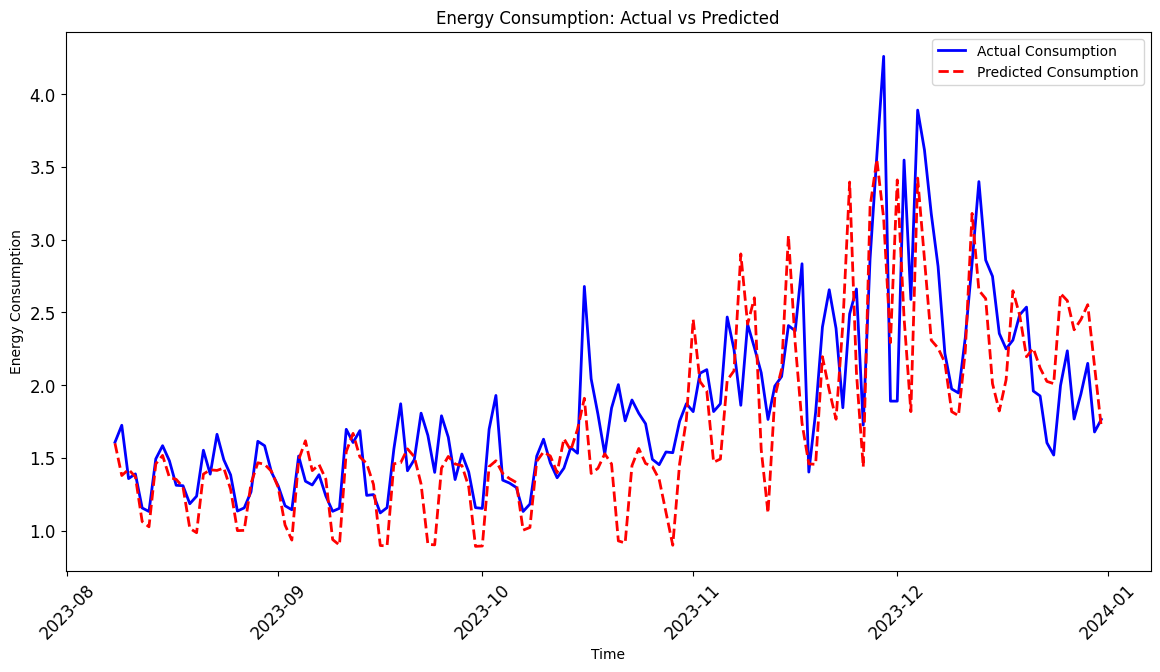

In [130]:
df_error = pd.DataFrame({
    'Actual Consumption': y_test,
    'Predicted Consumption': y_pred_rf
}, index=y_test.index)  # Use 'dates' as the index

# Ensure the DataFrame is sorted by date
df_error.sort_index(inplace=True)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df_error.index, df_error['Actual Consumption'], label='Actual Consumption', color='blue', linewidth=2)
plt.plot(df_error.index, df_error['Predicted Consumption'], label='Predicted Consumption', color='red', linestyle='--', linewidth=2)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()

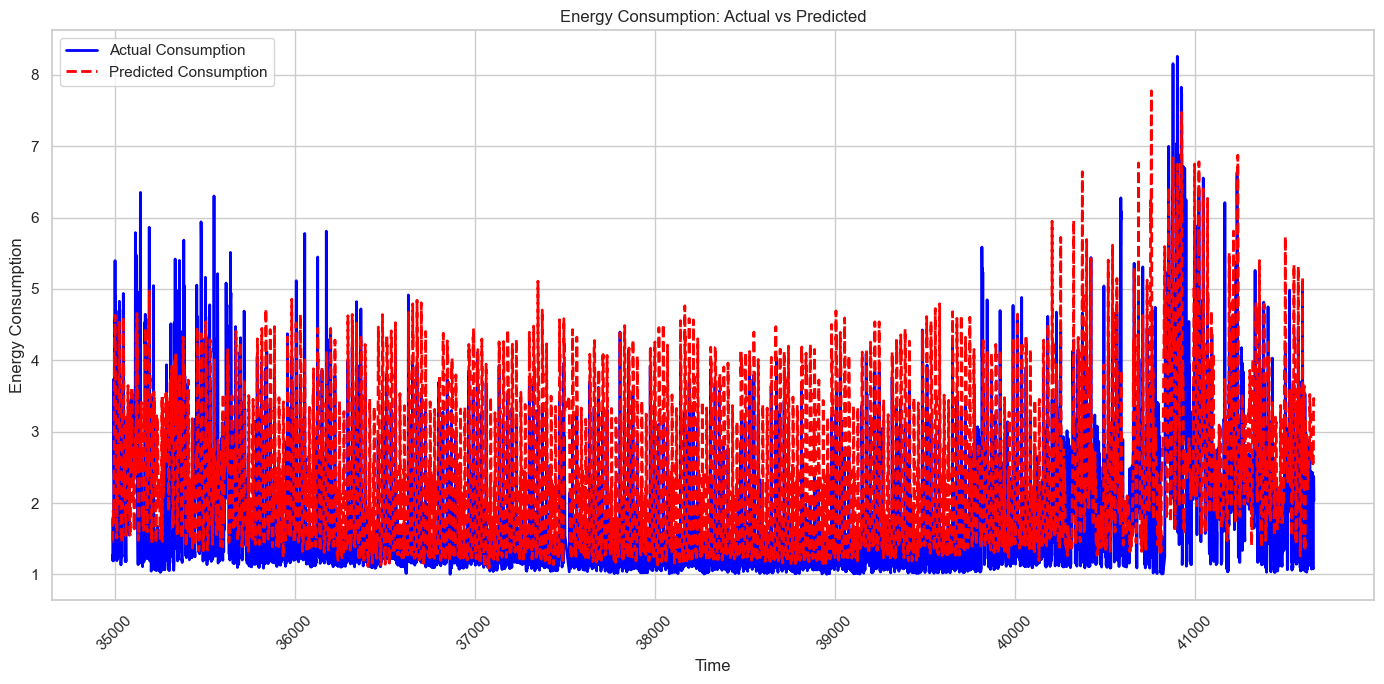

In [119]:

# Create a DataFrame for easier plotting
df_error = pd.DataFrame({
    'Actual Consumption': y_test,
    'Predicted Consumption': y_pred_rf
})

# Sort the DataFrame by date if it's not already sorted

# Plotting
sns.set_theme(style="whitegrid")  # This sets a nice background grid and improves overall aesthetics

plt.figure(figsize=(14, 7))
plt.plot( df_error['Actual Consumption'], label='Actual Consumption', color='blue', linewidth=2)
plt.plot( df_error['Predicted Consumption'], label='Predicted Consumption', color='red', linestyle='--', linewidth=2)

plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Optionally, you can limit the displayed range to a specific period for a clearer view
# plt.xlim([pd.Timestamp('YYYY-MM-DD'), pd.Timestamp('YYYY-MM-DD')])

plt.tight_layout()  # Adjust the layout to make room for the rotated date labels
plt.show()

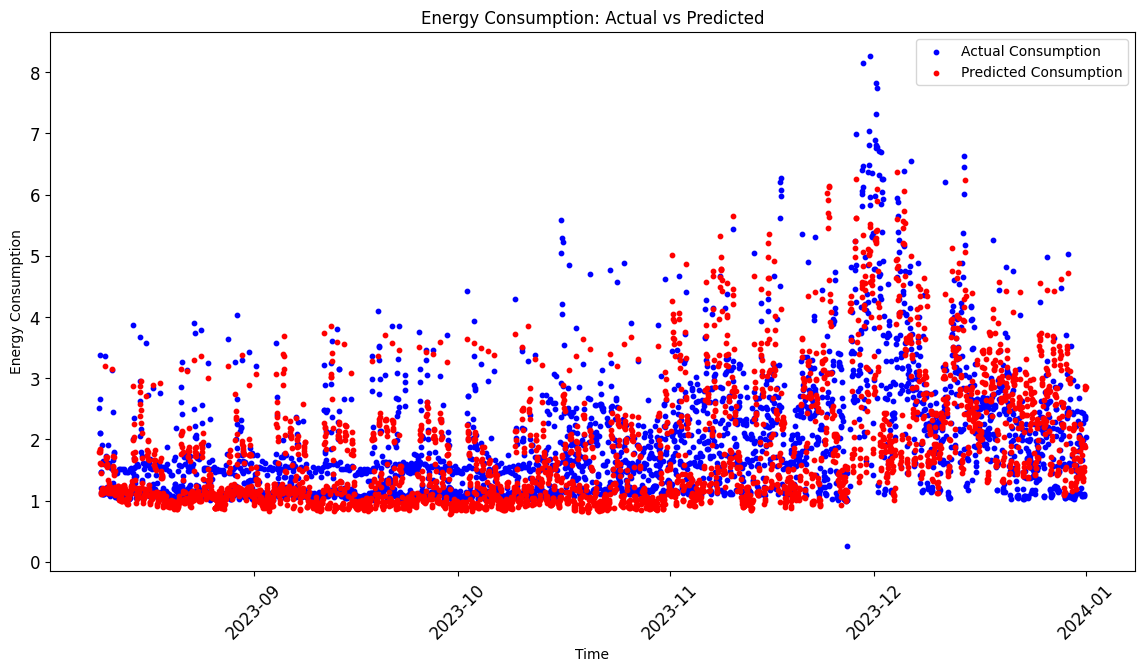

In [66]:
# Create a scatter plot for both actual and predicted consumption
plt.figure(figsize=(14, 7))
plt.scatter(df_error.index, df_error['Actual Consumption'], label='Actual Consumption', color='blue', s=10)  # Ensure s is set to a reasonable value for dots
plt.scatter(df_error.index, df_error['Predicted Consumption'], label='Predicted Consumption', color='red', s=10)

# # Add continuous lines through the dots for visual trend observation
# plt.plot(df_error.index, df_error['Actual Consumption'], color='blue', linewidth=2, alpha=0.5)
# plt.plot(df_error.index, df_error['Predicted Consumption'], color='red', linestyle='--', linewidth=2, alpha=0.5)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

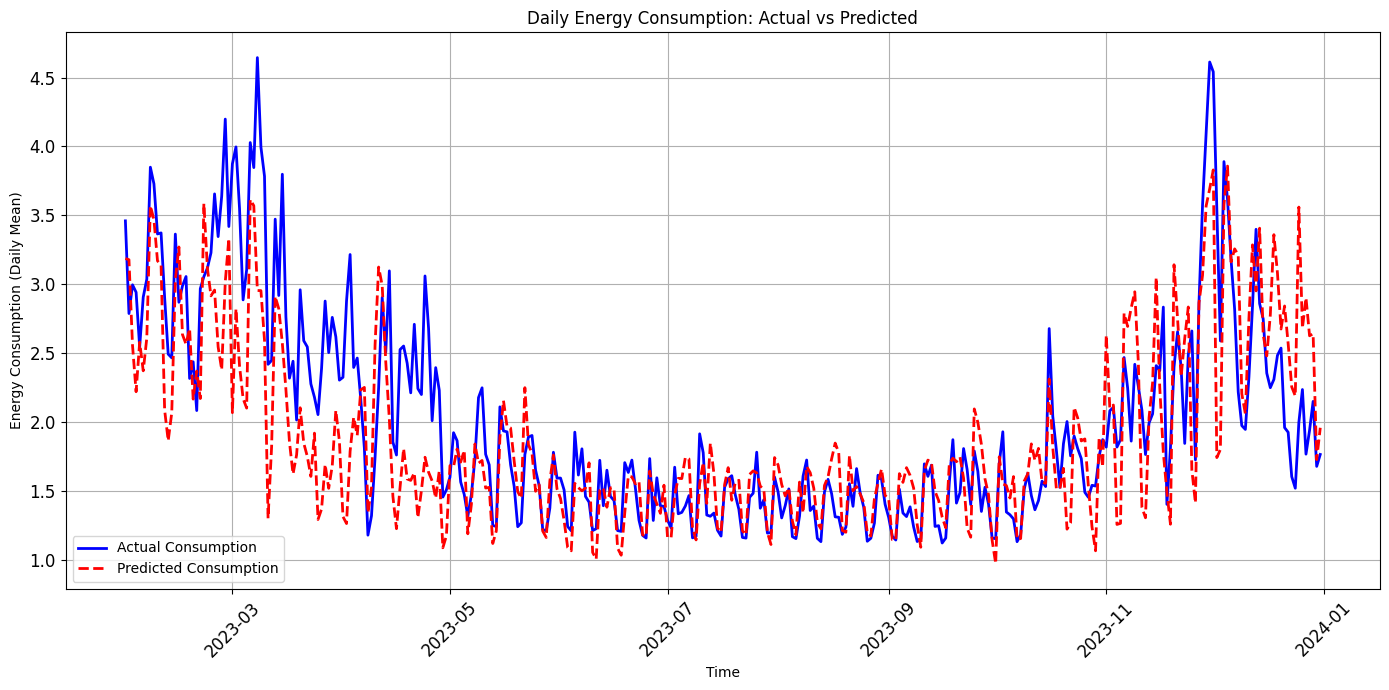

In [153]:
df_error = pd.DataFrame({
    'Actual Consumption': y_test,
    'Predicted Consumption': y_pred_rf
}, index=y_test.index)  # Use 'dates' as the index

daily_df_error = df_error.resample('D').mean()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(daily_df_error.index, daily_df_error['Actual Consumption'], label='Actual Consumption', color='blue', linewidth=2)
plt.plot(daily_df_error.index, daily_df_error['Predicted Consumption'], label='Predicted Consumption', color='red', linestyle='--', linewidth=2)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.title('Daily Energy Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (Daily Mean)')
plt.legend()
plt.grid(True)  # Optional: Add grid for better readability
plt.tight_layout()  # Adjust layout to make sure everything fits without overlap
plt.show()

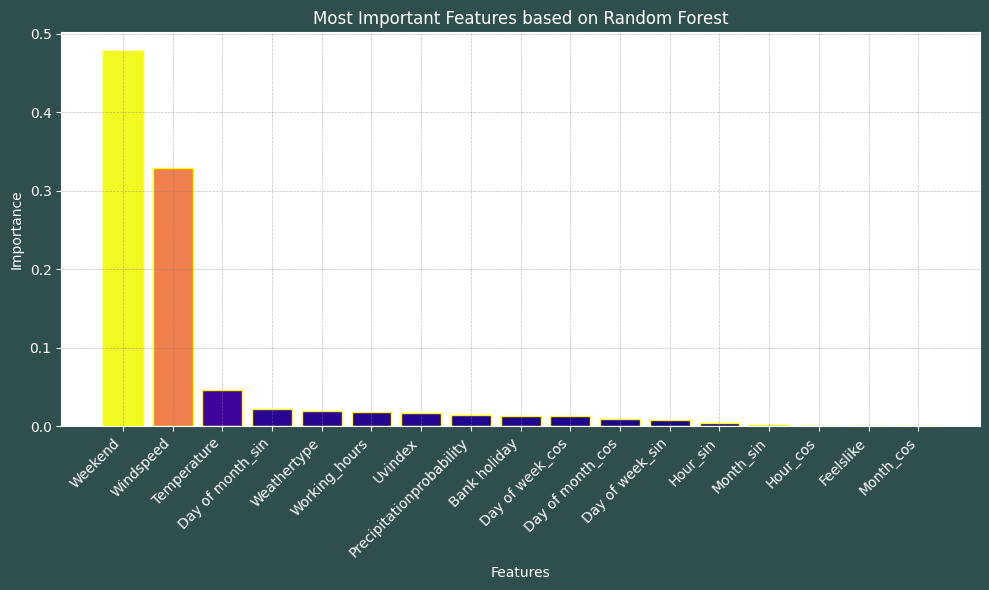

In [25]:
feature_names = X_train.columns
# Get feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order and select the top 10
indices = np.argsort(importances)
indices= indices[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

normalized_importances = importances[indices] / importances[indices].max()

# Generate a color for each importance score using the plasma colormap
colors = [plt.cm.plasma(i) for i in normalized_importances]

plt.figure(figsize=(10, 6), facecolor='darkslategray')
plt.title("Most Important Features based on Random Forest", color='white')

# Plot bars with the generated colors
for i, color in enumerate(colors):
    plt.bar(i, importances[indices][i], color=color, edgecolor='yellow')

# Assuming 'names' contains the feature names corresponding to 'indices'
plt.xticks(range(len(indices)), [names[i] for i in indices], rotation=45, ha='right', color='white')

plt.xlabel('Features', color='white')
plt.ylabel('Importance', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

for spine in plt.gca().spines.values():
    spine.set_edgecolor('white')

plt.tight_layout()
plt.show()

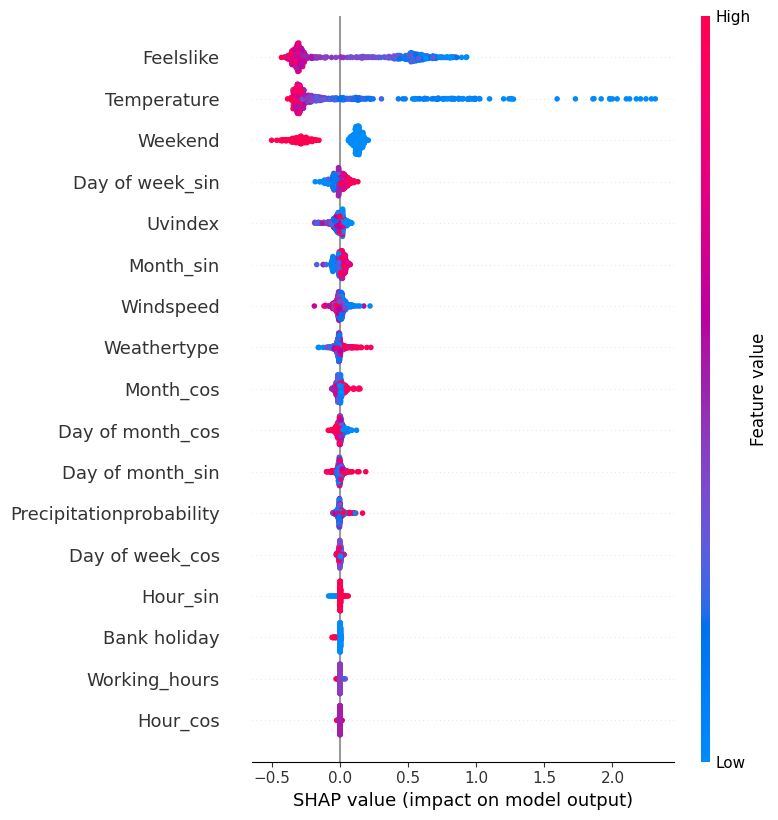

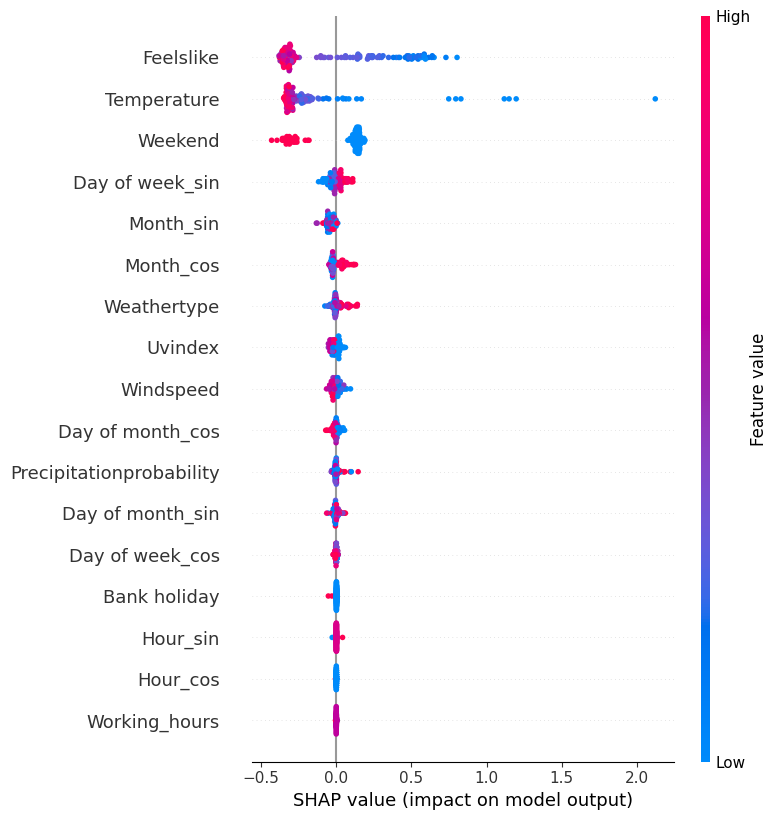

In [26]:
# Analyzing SHAP values for the training data
explainer_train = shap.TreeExplainer(rf_model)
shap_values_train = explainer_train.shap_values(X_train)
shap.summary_plot(shap_values_train, X_train, title="SHAP Summary Plot - Training Data")

# Analyzing SHAP values for the testing data
explainer_test = shap.TreeExplainer(rf_model)
shap_values_test = explainer_test.shap_values(X_test)
shap.summary_plot(shap_values_test, X_test, title="SHAP Summary Plot - Testing Data")


In [38]:
# Create a LIME explainer for regression
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    mode='regression'
)

# Explain an instance from the test set for regression
idx = 5  # Index of the instance to explain
exp = explainer.explain_instance(X_test.iloc[idx], rf_model.predict, num_features=10)
exp.show_in_notebook(show_table=True, show_all=False)

c:\AOB\AOB_Energy_Consumption_Analysis_Prediction\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\AOB\AOB_Energy_Consumption_Analysis_Prediction\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\AOB\AOB_Energy_Consumption_Analysis_Prediction\.venv\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

In [ ]:
# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    mode='regression'
)

# Choose a sample of instances to explain
sample_indices = np.random.choice(X_test.index, size=100, replace=False)  # Adjust size as needed
lime_results = []

for idx in sample_indices:
    instance = X_test.loc[idx]
    exp = explainer.explain_instance(data_row=instance, predict_fn=rf_model.predict, num_features=10)
    lime_results.append(exp.as_list())

# Convert results to DataFrame for analysis
lime_df = pd.DataFrame(index=sample_indices, columns=X_train.columns)

for idx, single_result in zip(sample_indices, lime_results):
    for feature, value in single_result:
        lime_df.loc[idx, feature] = value

# Aggregate results
feature_importance_summary = lime_df.mean().sort_values(ascending=False)

print(feature_importance_summary)

In [ ]:

# Single feature partial dependence plot
feature_to_plot = 'Temprature'  # Replace 'feature_name' with the actual name of the feature you want to analyze
pdp_dist = pdp.PDPIsolate(model=rf_model, dataset=X_train, model_features=X_train.columns.tolist(), feature=feature_to_plot)
pdp.PDPIsolatePlotEngine(pdp_dist, feature_to_plot)
plt.show()

# Partial dependence plot for interaction between two features
features_to_plot = ['Weekend', 'feelslike']  # Replace 'feature1' and 'feature2' with actual feature names
inter1 = pdp.pdp_interact(model=rf_model, dataset=X_train, model_features=X_train.columns.tolist(), features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

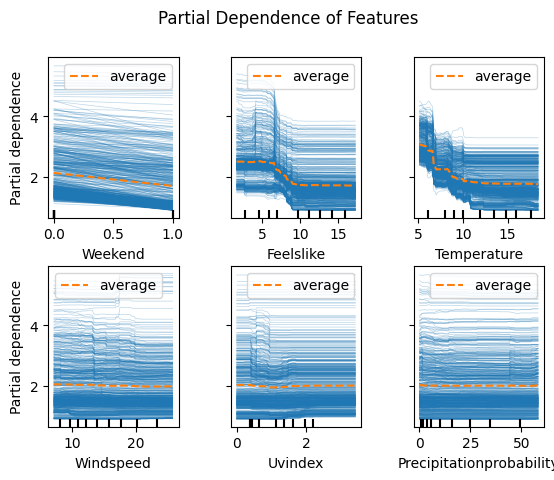

In [50]:
from sklearn.inspection import PartialDependenceDisplay

features = ['Weekend', 'Feelslike','Temperature', 'Windspeed','Uvindex','Precipitationprobability']  # Feature names as strings
display = PartialDependenceDisplay.from_estimator(
    rf_model,
    X_train,
    features,
    kind="both"  # Can display individual and average effects
)
display.figure_.suptitle('Partial Dependence of Features')
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)  # Adjust spacing if necessary
plt.show()


In [51]:
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the importance and corresponding std
importance_sorted_idx = np.argsort(result.importances_mean)[::-1]
importances = pd.DataFrame({
    "features": X_test.columns[importance_sorted_idx],
    "importance_mean": result.importances_mean[importance_sorted_idx],
    "importance_std": result.importances_std[importance_sorted_idx]
})

# Print the feature importance
print(importances)

                    features  importance_mean  importance_std
0                Temperature         0.421451        0.042380
1                  Feelslike         0.325152        0.023856
2                    Weekend         0.135743        0.016494
3            Day of week_sin         0.014867        0.009532
4                  Windspeed         0.006344        0.006030
5                Weathertype         0.002255        0.007175
6                    Uvindex         0.001309        0.006415
7               Bank holiday         0.000977        0.000642
8                   Hour_sin         0.000954        0.000593
9              Working_hours         0.000137        0.000290
10  Precipitationprobability        -0.000051        0.003540
11                  Hour_cos        -0.000251        0.000638
12          Day of month_cos        -0.001417        0.003669
13                 Month_sin        -0.001693        0.002259
14           Day of week_cos        -0.001818        0.002170
15      

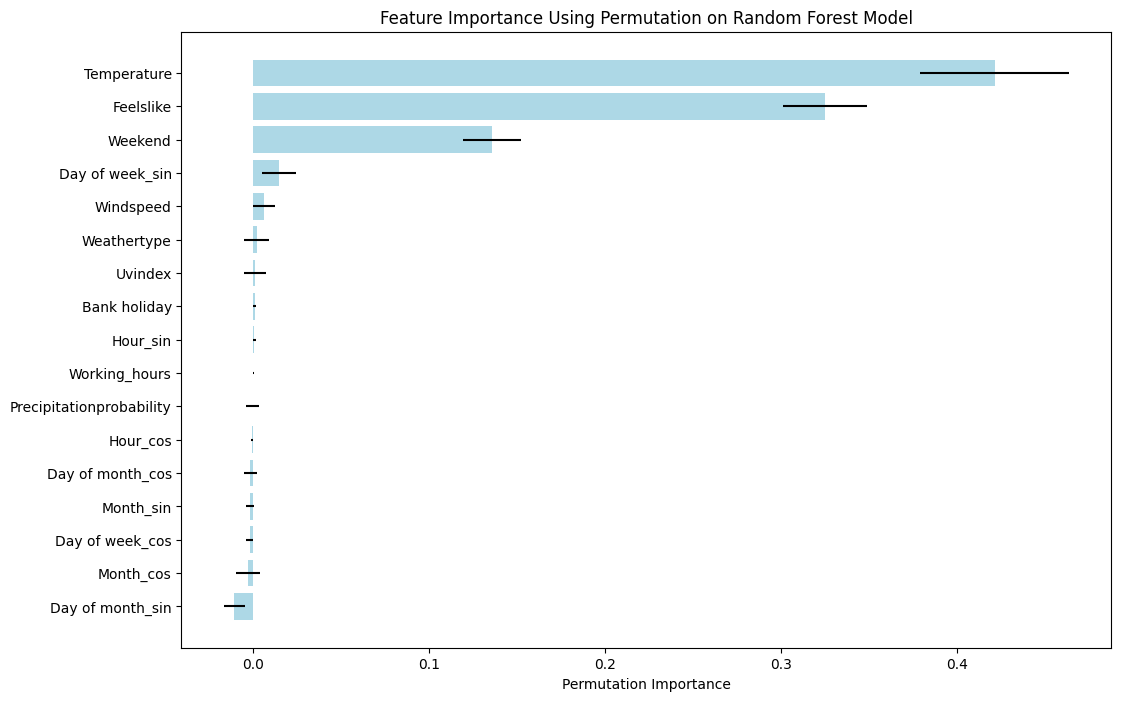

In [53]:
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the importances and their standard deviations
importances = result.importances_mean
std = result.importances_std
features = X_test.columns

# Sorting the features by importance
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], color='lightblue', xerr=std[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance Using Permutation on Random Forest Model')
plt.gca().invert_yaxis()  # Invert axis to have the most important at the top
plt.show()

In [68]:
def replace_with_nearest_nonzero(series):
    """ Replace 0 with the nearest non-zero value in a pandas Series. """
    nonzero_indices = series.nonzero()[0]
    for i in range(len(series)):
        if series[i] < 0.2:
            # Find the nearest non-zero index
            nearest_nonzero_index = min(nonzero_indices, key=lambda x: abs(x-i))
            series[i] = series[nearest_nonzero_index]
    return series

In [69]:
df['Total_aob_energy'] = replace_with_nearest_nonzero(df['Total_aob_energy'])

AttributeError: 'Series' object has no attribute 'nonzero'

In [70]:
# df1 = df

In [80]:
# def replace_with_nearest_nonzero(series):
#     """ Replace 0 with the nearest non-zero value in a pandas Series. """
#     # Convert series to numpy array
#     arr = series.to_numpy()
#     # Get indices where the array is not zero
#     nonzero_indices = np.nonzero(arr)[0]
#     # Iterate over all elements of the array
#     for i in range(len(arr)):
#         if arr[i] < 0.3:
#             # Calculate distances to all non-zero elements
#             distances = np.abs(nonzero_indices - i)
#             # Find the index of the nearest non-zero element
#             nearest_index = nonzero_indices[np.argmin(distances)]
#             # Replace zero with the nearest non-zero element
#             arr[i] = arr[nearest_index]
#     return arr

# # Apply the function to the 'Total_aob_energy' column
# df1['Total_aob_energy'] = replace_with_nearest_nonzero(df1['Total_aob_energy'])


In [101]:
zero_count = (df["Total_aob_energy"] < 0.75).sum()

In [102]:
print(zero_count)

81


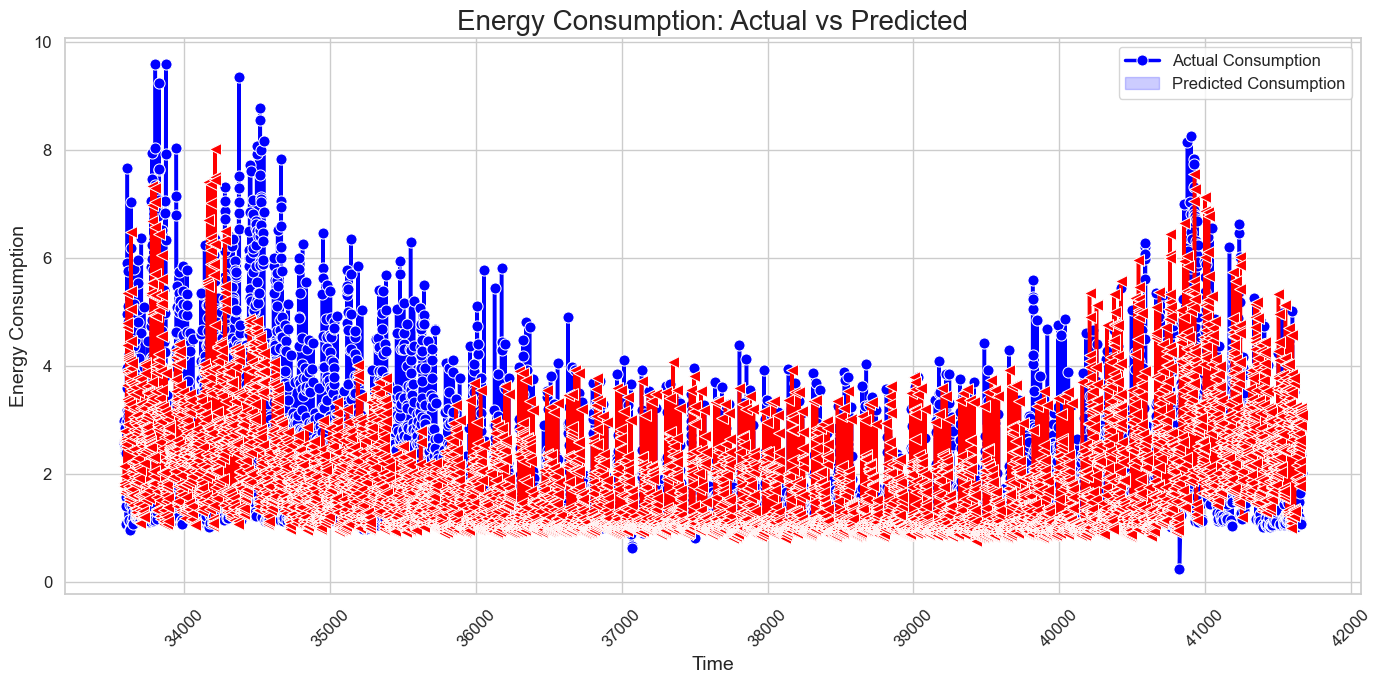

In [113]:
sns.set(style="whitegrid")  # This sets a nice background grid and improves overall aesthetics

# Plotting with Seaborn's lineplot function for automatic handling of datetime x-axis and improved aesthetics
plt.figure(figsize=(14, 7))

sns.lineplot(data=df_error, palette=['blue', 'red'], linewidth=2.5, dashes=False, markers=["o", "<"], markersize=8)

plt.title('Energy Consumption: Actual vs Predicted', fontsize=20)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.legend(labels=['Actual Consumption', 'Predicted Consumption'], fontsize=12)

# Improve readability of the x-axis labels
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adjust the layout
plt.tight_layout()

In [121]:
# Visualise the scatterplot matrix: training data
df_train = X_train.join(y_train)

sns.pairplot(df_train, hue="Total_aob_energy")
plt.show()

KeyboardInterrupt: 

In [124]:
df_test = X_test.join(y_test)

sns.pairplot(df_test, hue="Total_aob_energy")
plt.show()

KeyboardInterrupt: 